Plot heatmap for higher bot infiltration gamma 0.1 beta 0.01 (2 runs)

In [1]:
from matplotlib import cm 
import gzip
import matplotlib.pyplot as plt
import csv
import numpy as np 
import glob 
import json
import os
from matplotlib import cm
import infosys.utils as utils 
from collections import defaultdict
cmap = cm.get_cmap('inferno', 10)

In [2]:
ABS_PATH = '/N/slate/baotruon/marketplace'
DATA_PATH = os.path.join(ABS_PATH, "data")
# RES_PATH = os.path.join(ABS_PATH, "results")

all_configs = json.load(open(os.path.join(DATA_PATH,'all_configs.json'),'r'))
config_fpath = os.path.join(DATA_PATH,'all_configs.json')

In [3]:
def read_json_compressed(fpath):
    data=None
    try:
        fin = gzip.open(fpath, 'r')
        json_bytes = fin.read()  
        json_str = json_bytes.decode('utf-8')
        data = json.loads(json_str)
    except Exception as e:
        print(e)
    return data

In [4]:
pprint = {'gamma':'$\\gamma$','theta': '$\\theta$', 'beta':'$\\beta$', 'phi': '$\phi$', 
        'quality': 'Relative Average Quality', 'discriminative_pow': 'Discriminative Power', 'diversity': 'Diversity'}
    
BETA = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]
GAMMA = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.02, 0.05, 0.1, 0.2, 0.5]
TARGETING = [None, 'hubs', 'partisanship', 'conservative', 'liberal', 'misinformation']
PHI_LIN = list(range(1,11))
THETA = [1,2,4,6,8,10,12,14]

heatmap_config = {'vary_thetagamma': {'x':'theta', 'y':'gamma', 'xvals':THETA, 'yvals':GAMMA},
'vary_phigamma': {'x':'phi', 'y':'gamma', 'xvals':PHI_LIN, 'yvals':GAMMA},
'vary_betagamma': {'x':'beta', 'y':'gamma', 'xvals':BETA, 'yvals':GAMMA},
'vary_thetaphi': {'x':'theta', 'y':'phi', 'xvals':THETA, 'yvals':PHI_LIN}
}


In [5]:
xticks = {
        'vary_thetagamma': {'vals': THETA, 'label': pprint['theta']},
        'vary_phigamma': {'vals': PHI_LIN, 'label': pprint['phi']},
        'vary_betagamma': {'vals': BETA, 'label': pprint['beta']},
        'vary_thetaphi': {'vals': THETA, 'label': pprint['theta']},
    }

In [6]:
# Get data from specific directory
def read_raw_data_singlerun(result_dir, exp_type='vary_thetaphi', file_prefix='none'):
    #prefix: the targeting strategy, used to filter results specific to that targeting strategy
    respath = glob.glob('%s/%s*.json' %(result_dir, file_prefix))
    resfiles = [i.split('%s/' %result_dir)[1].replace('.json','') for i in respath]
#     print(resfiles)
    #fill in other config
    all_configs = json.load(open(config_fpath,'r'))

    params = {}
    results = {}
    #TODO: simplify this!! 
    for file in resfiles: 
#         print(file)
        if file in all_configs[exp_type].keys():
            params[file] = all_configs[exp_type][file]
#             print(params)
            fpath = os.path.join(result_dir,'%s.json' %file)
            res = json.load(open(fpath,'r'))

            if res is not None:
                res = utils.update_dict(res, params[file])

                results[file] = res

    all_results = results.values()
    return results, all_results

In [7]:
def get_heatmap_data(all_results, exp_type='vary_thetaphi', cell_type='quality'):
#     results: dict of exp_name - {dict of params + list of qualities across runs}

    x = heatmap_config[exp_type]['x']
    y = heatmap_config[exp_type]['y']

    results = defaultdict(lambda: [])
    for idx, yval in enumerate(heatmap_config[exp_type]['yvals']):
        for xval in heatmap_config[exp_type]['xvals']:
            if cell_type=='discriminative_pow':
                #Fill 0 for exps that haven't finished running yet
                vals = [res[cell_type][0] for res in all_results if res[x]==xval and res[y]==yval]
                results[yval] += [np.mean(vals) if len(vals)>0 else 0] #change else back to 0
            else:
                vals = [res[cell_type] for res in all_results if res[x]==xval and res[y]==yval]
                results[yval] += [np.mean(vals) if len(vals)>0 else 0]

    data = np.array([row for row in results.values()])
    return data

In [8]:
PLOT_PATH = '/N/slate/baotruon/marketplace/plots/vary_thetaphi_2runs'
RES_PATH = '/N/slate/baotruon/marketplace/results/vary_thetaphi_2runs'

In [9]:
cell_type='quality'
exp_type='vary_thetaphi'
_, results1 = read_raw_data_singlerun(RES_PATH, exp_type=exp_type, file_prefix='none')
data1= get_heatmap_data(results1, exp_type=exp_type, cell_type=cell_type)

In [25]:
_, results2 = read_raw_data_singlerun(RES_PATH, exp_type=exp_type, file_prefix='hubs')
data2= get_heatmap_data(results2, exp_type=exp_type, cell_type=cell_type)

In [26]:
assert data1.all()==data2.all()

In [27]:
# PLOT_PATH = '/N/slate/baotruon/marketplace/results/vary_thetaphi_1runs'
utils.make_sure_dir_exists(RES_PATH, 'plots')

True

In [10]:
def compare_targeting_heatmap(exp_type='vary_thetaphi', cell_type='quality', prefixes=['none','misinformation']):
    plt.clf()
    figure, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5), facecolor='w')
    for ax, prefix in zip([ax1,ax2], prefixes):
        _, all_results = read_raw_data_singlerun(RES_PATH, exp_type=exp_type, file_prefix=prefix)
        data= get_heatmap_data(all_results, exp_type=exp_type, cell_type=cell_type)
        utils.draw_heatmap(ax, data, xticks[exp_type]['vals'], PHI_LIN, xticks[exp_type]['label'], pprint['phi'], cmap, cell_type, vmax=None, vmin=None)
        ax.set_title('%s targeting' %prefix)
    figure.tight_layout()
    if utils.make_sure_dir_exists(PLOT_PATH, ''):
        plt.savefig(os.path.join(PLOT_PATH,'%s%s.png' %(prefixes[0], prefixes[1])), dpi=300)
    plt.show()

<Figure size 432x288 with 0 Axes>

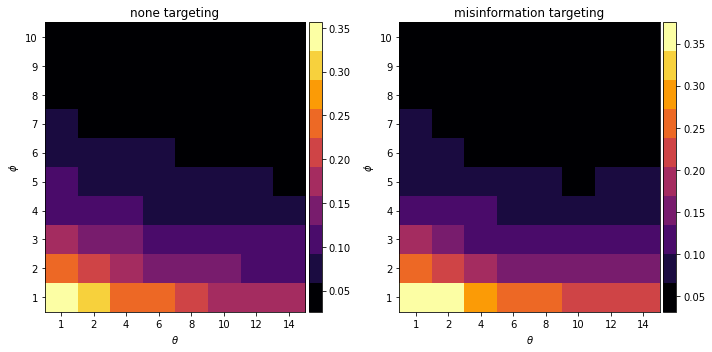

In [11]:
compare_targeting_heatmap(exp_type='vary_thetaphi', cell_type='quality', prefixes=['none','misinformation'])


<Figure size 432x288 with 0 Axes>

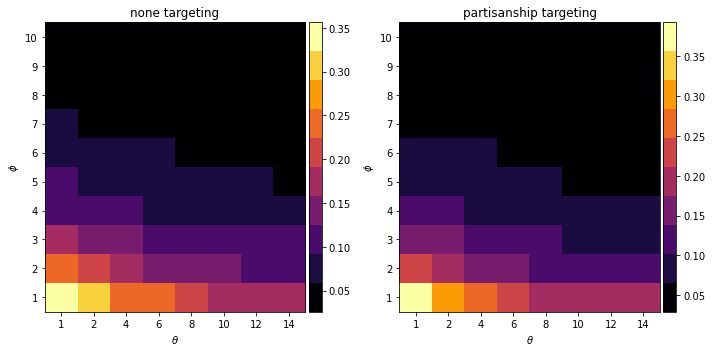

In [12]:
compare_targeting_heatmap(exp_type='vary_thetaphi', cell_type='quality', prefixes=['none','partisanship'])

<Figure size 432x288 with 0 Axes>

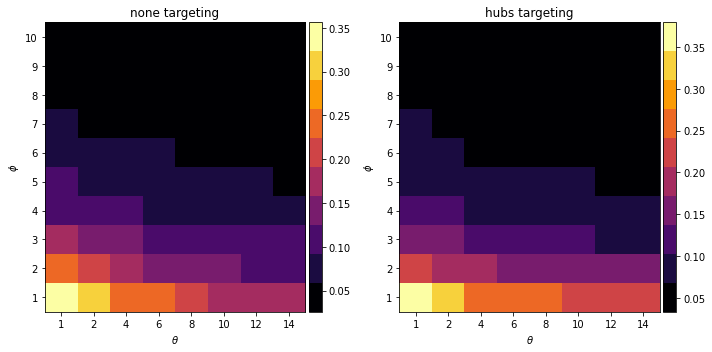

In [13]:
compare_targeting_heatmap(exp_type='vary_thetaphi', cell_type='quality', prefixes=['none','hubs'])